# Introduction

### Star Formation Rate Comparison Program

This script will be split into different sections for simplicity, with comments explaining each section of code.

> Note: This is an updated version of the original script that I created the first time I did this study.

# IMPORTANT NOTE!

For this program to work, each `.fits` file needs to follow a specific naming scheme.

**Check out [the wiki](https://github.com/Wo0fle/SFRCP/wiki) for more information!**

## Imports

In [10]:
import csv # to import/read .csv files (comma seperated values)
import numpy as np # to do cool math stuff, also export to .csv files
from numpy import genfromtxt # create np array from csv file
import matplotlib.pyplot as plt # to plot stuff in graphs and to create images of galaxies
from astropy.io import fits # to read/import all the stuff in the .fits files
from astropy.wcs import WCS # to understand the World Coordinate System (WCS)
import astropy.units as u # to make sure units are consistent across the program

# Section 1: Data Retrieval

## Setup

In [11]:
prefix = 'ORIGINAL GALAXY FITS/' # the folder containing every galaxies' .fits files
suffix = '.fits' # file extension for the files containing the data about each galaxy
w1 = 'w1_' # in front of every .fits file that is WISE 1 data -- denotes WISE 1 data
w3 = 'w3_' # denotes WISE 3 data
NUV = 'NUV_' # denotes NUV data
FUV = 'FUV_' # denotes FUV data
spiral = 'Spiral' # compared against GALAXY INFO.csv to check galaxy type
elliptical = 'Elliptical' # same as above

""" note to self: add w2 and w4? """

orig_galaxies_list = [
    'NGC 300',
    'M 99',
    'NGC 3938',
    'NGC 3184',
    'M 100', 
    'M 74',
    'NGC 1304',
    'NGC 3265',
    'NGC 855',
    'NGC 1404', 
    'NGC 584',
    'NGC 5866'
]
# the list of every galaxies' name that has a .fits file, exactly as it appears in the .fits file
# (common name, not PGC identifier)

galaxies_list_fits = [sub + suffix for sub in orig_galaxies_list]
# adds '.fits' to the end of every galaxies' name

with open('GALAXY INFO.csv') as csvfile: galaxy_info = list(csv.reader(csvfile))
# convert GALAXY INFO.csv into a list
# referenced later to retrieve galaxy name, radius, and type (elliptical or spiral)

sub_sec = 50 # amount of subsections to measure data in

## WISE Data Retrieval

In [12]:
w1_galaxies_list = [w1 + sub for sub in galaxies_list_fits]
# add 'w1_' to the front of each galaxy name (that already has .fits at the end of each)
w3_galaxies_list = [w3 + sub for sub in galaxies_list_fits]
# add 'w3_' to front

wise_galaxies_list = w1_galaxies_list + w3_galaxies_list
# combine the two lists from above into one large list containing each file name
# referenced later to create the variable galaxy_name

galaxies_list_for_data = [prefix + sub for sub in wise_galaxies_list]
# add 'ORIGINAL GALAXY FITS/' to front of each term in wise_galaxies_list
# used so that SFRCP can actually find/read the files

In [13]:
best_fit_eqs = []
# used to create a csv with equations of lines of best fit for sum and mean of SFR graphs and other info
# list created in this cell so it doesn't keep appending after being run multiple times

for current_galaxy, current_galaxy_for_data in zip(wise_galaxies_list, galaxies_list_for_data):
    # repeat the program for each term in wise_galaxies_list/galaxies_list_for_data
    # create variable current_galaxy, which is the current galaxy (wow!) in wise_galaxies_list
    # create variable current_galaxy_for_data, which is the current galaxy but readable by SFRCP because it has prefix at start
    
    galaxy_name = current_galaxy[3:-5]
    # each galaxies' name (wow!)
    # removed the 'w1_'/'w3_' at the start and '.fits' at the end of each galaxies' file name
    
    for row in galaxy_info: # go through each row in galaxy_info 
        if galaxy_name == row[0]: # if galaxy_name is the same as the galaxies' name in GALAXY INFO.csv, execute the program
            galaxy_radius =  float(row[2]) * u.arcsec.to(u.deg)
            # retrieve galaxies' radius from GALAXY INFO.csv (in arcseconds)
            # convert to float value so it can be used for math
            # convert to degrees to keep units consistent
            
            galaxy_type = row[3] # check GALAXY INFO.csv to see if the current galaxy is spiral or elliptical
            galaxy_id = current_galaxy[0:3] # check GALAXY INFO.csv to see if the current galaxy file is WISE 1 or WISE 3 data
            
            data = fits.getdata(current_galaxy_for_data) # retrieve data from current galaxy as array
            header = fits.getheader(current_galaxy_for_data) # retrieve header from current galaxy
            w = WCS(header) # create WCS object from header to get pixel coords
            rows, cols = np.indices(data.shape) # create 2d array using indices of data, split indices into rows and columns
            ra, dec = w.all_pix2world(cols, rows, 1) # convert pix coords to world coords, which are right acsension (ra) and declination (dec) using the previous indices
            ra_ctr = header['CRVAL1'] # retrieve center ra from header
            dec_ctr = header['CRVAL2'] # retrieve center dec

            dist_array = np.sqrt((ra_ctr - ra)**2 + (dec_ctr - dec)**2)
            # based off the Pythagorean theorem: a**2 + b**2 = c**2
            # creates an array of every distance in the image using ra_ctr/dec_ctr and ra/dec of other points in the image
            radius_array = np.zeros(sub_sec) # creates an empty array of (in this case) 50 values to be filled in later with radii
            
            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec # set radius to (in this case) 1/50th of the original
                radius_array[i] = radius # add this value to radius_array
                
            bins_mean = np.zeros(sub_sec) # create array with sub_sec slots (full of 0s right now) to use for mean SFRs
            bins_sum = np.zeros(sub_sec) # create array to use for sum of SFRs

            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec # set radius to (in this case) 1/50th of the original
                radius_inds = np.where(dist_array < radius) # get all locations where distance is less than the current radius
                im_vals = data[radius_inds]
                radius_mean = np.mean(im_vals)
                radius_sum = np.sum(im_vals)
                
                if (galaxy_id == w1):
                    """"""""""""""""""""""""""""""""""""""""""""
                    stellar_mass_mean = 3.3e2 * radius_mean
                    stellar_mass_sum = 3.3e2 * radius_sum
                    """"""""""""""""""""""""""""""""""""""""""""
                    
                    """
                        wrong formula -- (Section 3.2 -- WISE1 to Stellar Mass)
                        soooooo how do I get SFR?
                    """

                    bins_mean[i] = stellar_mass_mean
                    bins_sum[i] = stellar_mass_sum
                    
                if (galaxy_id == w3):
                    sfr_mean = 3.77e-3 * radius_mean 
                    sfr_sum = 3.77e-3 * radius_sum
                    # formula for SFR from Leroy et al. (2019) -- doi: 10.3847/1538-4365/ab3925
                    bins_mean[i] = sfr_mean # save the mean SFR for this radius in bins_mean
                    bins_sum[i] = sfr_sum # save the sum of SFR for this radius in bins_sum

            log_radii = np.log(radius_array)

            a, b = np.polyfit(log_radii, bins_mean, 1)
            curve_output = a * log_radii + b

            best_fit_eqs.append(f'Mean,{galaxy_id[:-1]},{galaxy_name},y = {a} ln(x) - {-b},{a},{b}')

            plt.plot(radius_array, bins_mean, 'b.', label='Actual Data') # create plot with radius_array as x axis and bins_mean as y axis -- small blue points are plotted
            plt.plot(radius_array, curve_output, 'k', label=f'Curve fit: y = {a.round(3)} ln(x) - {-b.round(3)}') # add line of best fit (logarithm)
            plt.legend(loc='upper right')
            plt.xlabel('Radius (degrees)') # label x axis
            plt.ylabel('Mean $\Sigma_{SFR}$ (per $kiloparsec^2$)') # label y axis
            plt.title(galaxy_name + ' Mean $\Sigma_{SFR}$ Within Certain Radii') # title the graph
            plt.savefig(f'saved avg sfr plots/{galaxy_id[:-1]}/{galaxy_type.lower()}-{galaxy_name}-avg.png') # save avg sfr plot
            plt.close() # close the plot to prevent overlap/errors in the program

            a, b = np.polyfit(log_radii, bins_sum, 1)
            curve_output = a * log_radii + b

            best_fit_eqs.append(f'Sum,{galaxy_id[:-1]},{galaxy_name},y = {a} ln(x) + {b},{a},{b}')

            plt.plot(radius_array, bins_sum, 'r.', label='Actual Data') # create plot with radius_array as x axis and bins_sum as y axis -- small red points are plotted
            plt.plot(radius_array, curve_output, 'k', label=f'Curve fit: y = {a.round(3)} ln(x) + {b.round(3)}') # add line of best fit (logarithm)
            plt.legend(loc='lower right')
            plt.xlabel('Radius (degrees)')
            plt.ylabel('Sum of $\Sigma_{SFR}$ (per $kiloparsec^2$)')
            plt.title(galaxy_name + ' Sum of $\Sigma_{SFR}$ Within Certain Radii')
            plt.savefig(f'saved sum of sfr plots/{galaxy_id[:-1]}/{galaxy_type.lower()}-{galaxy_name}-sum.png') # save sum of sfr plot
            plt.close()

            median = np.median(data)
            deviations = abs(data - median)
            mad = np.median(deviations)
            plt.imshow(data, vmin = median - 3*mad, vmax = median + 30*mad, origin='lower', cmap='afmhot')
            plt.title(f'{galaxy_id[:-1].upper()} -- {galaxy_name}')
            plt.savefig(f'saved galaxy images/{galaxy_id[:-1]}/{galaxy_type.lower()}-{galaxy_name}.png')
            plt.close()

            np.savetxt(f'saved raw data/{galaxy_id[:-1]}/{galaxy_type.lower()}/{galaxy_name}-raw_mean.csv', bins_mean, delimiter=',') # save bins_mean array as a .csv file, with delimiter ',', in corresponding folder
            np.savetxt(f'saved raw data/{galaxy_id[:-1]}/{galaxy_type.lower()}/{galaxy_name}-raw_sum.csv', bins_sum, delimiter=',') # save bins_sum array as a .csv file, with delimiter ',', in corresponding folder
            np.savetxt(f'saved raw data/{galaxy_id[:-1]}/{galaxy_type.lower()}/{galaxy_name}-radius_array.csv', radius_array, delimiter=',') # save radius_array array as a .csv file, with delimiter ',', in corresponding folder

with open('saved_best_fit_equations.csv', 'w') as f: 
    f.write(f'Mean/Sum,Wavelength,Galaxy Name,Equation of Line of Best Fit,A,B\n')
    for row in best_fit_eqs:
        f.write(row + '\n')

maybe k/x is the way to go? idk

50.158107038830295


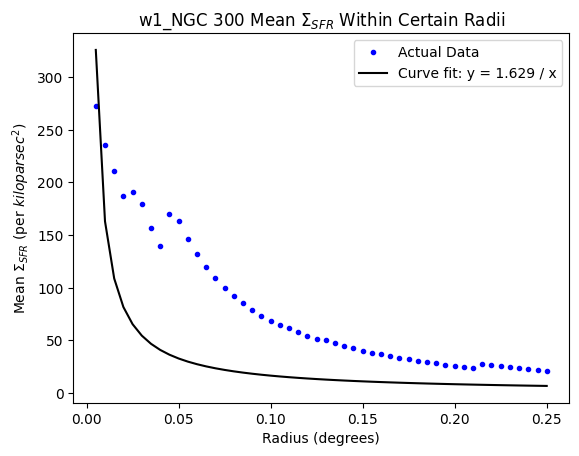

231.72081088260364


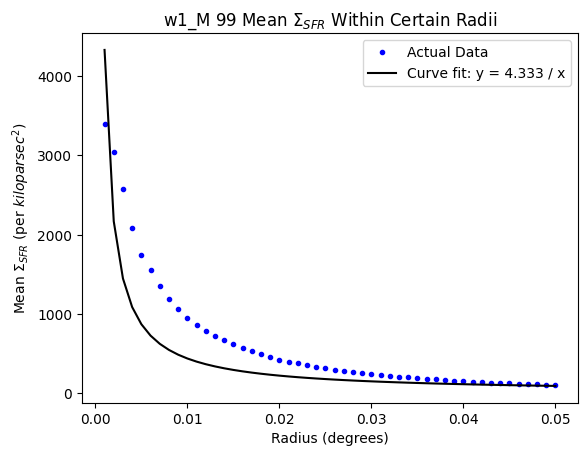

158.63812362598412


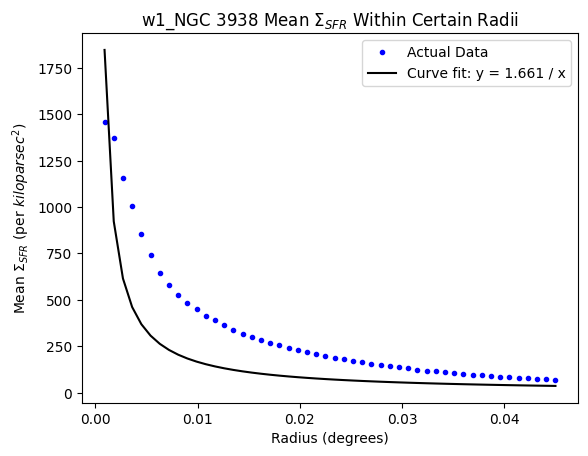

77.5451106824456


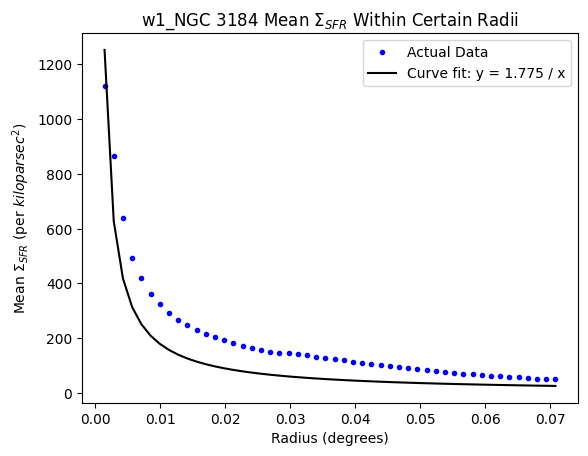

-1.5122281570750136


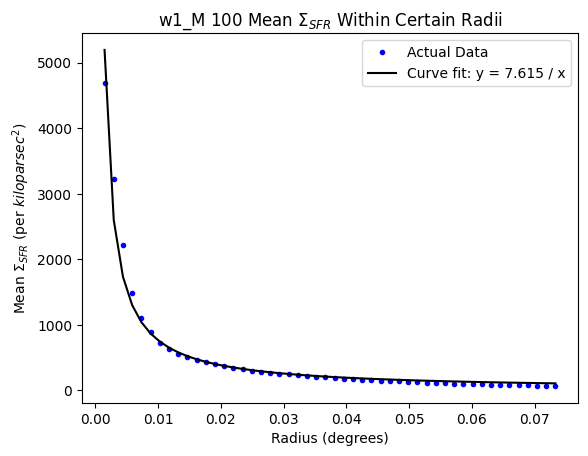

45.32162466090755


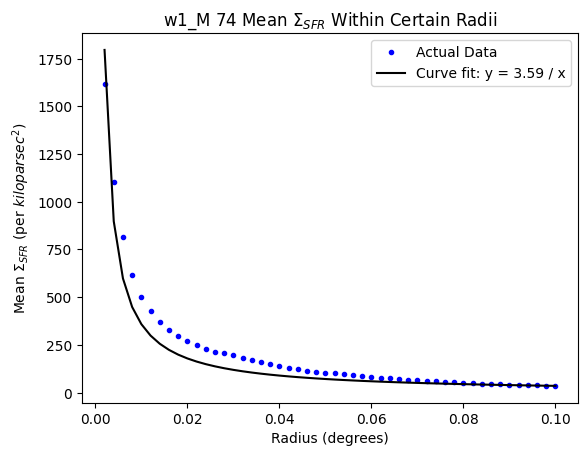

272.7671488644109


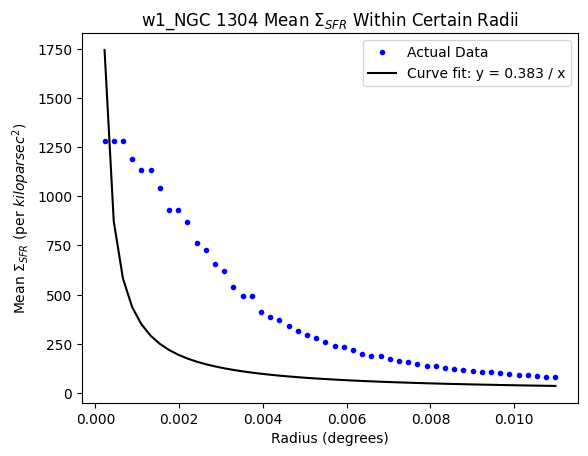

828.1301879789162


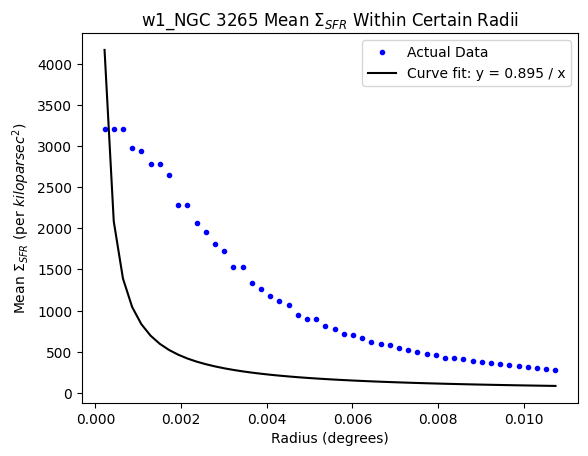

54.565096302603614


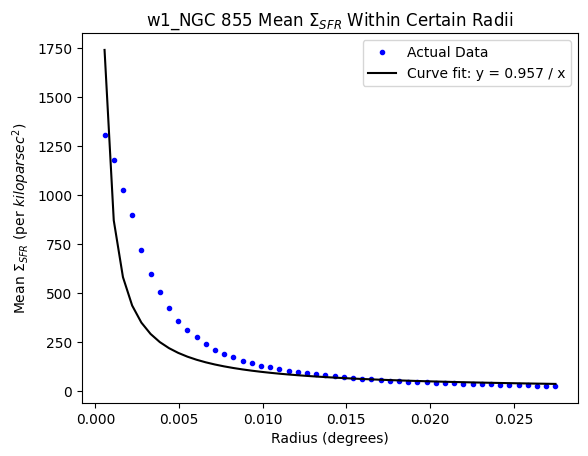

-296.09834550076334


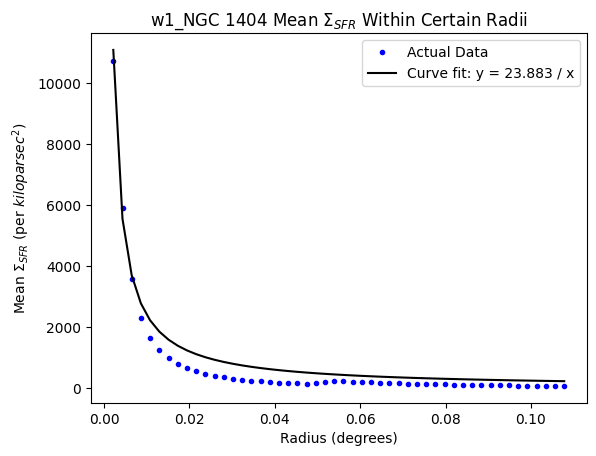

161.17965106600192


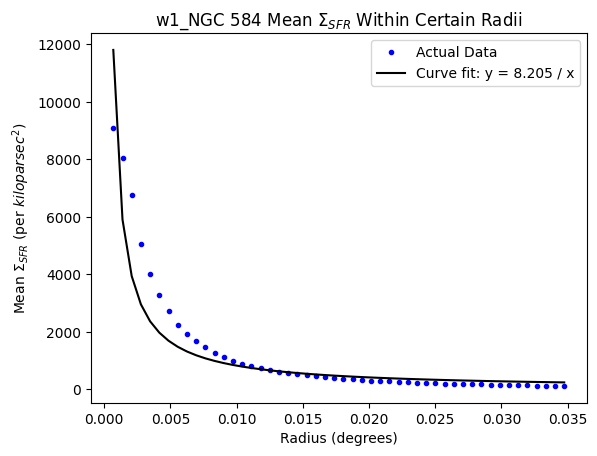

177.87259834135943


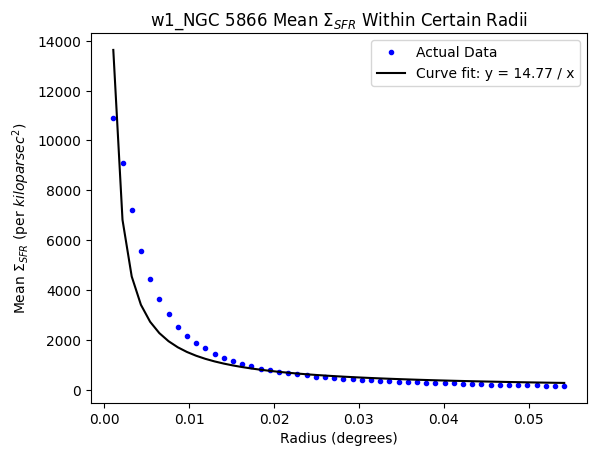

0.0005793049605609147


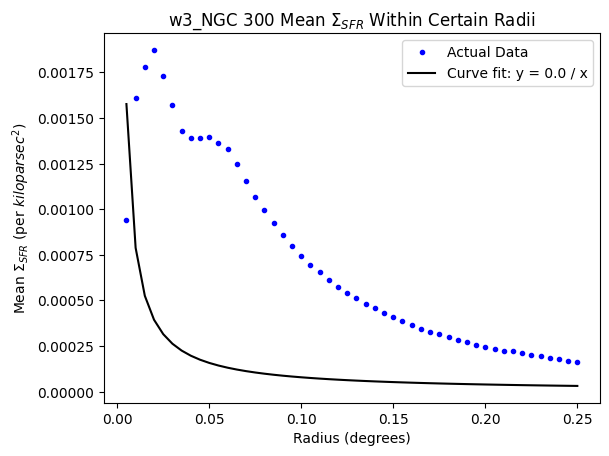

0.014088666401214832


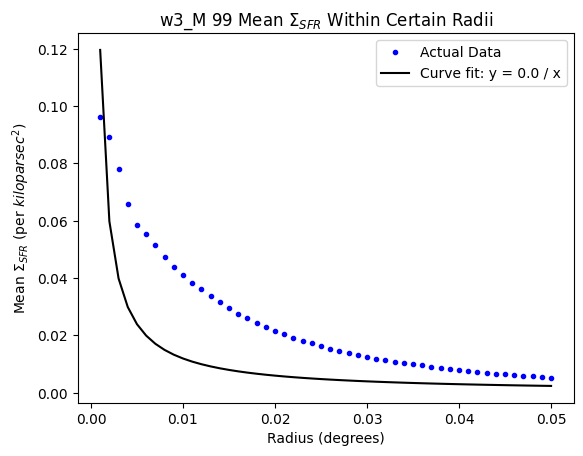

0.00503714766756983


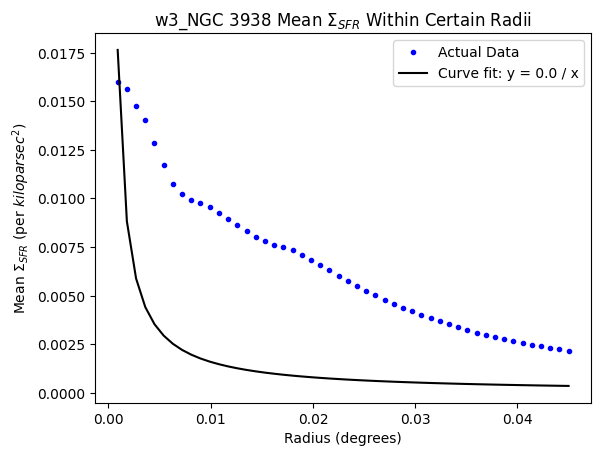

0.0013261965693078413


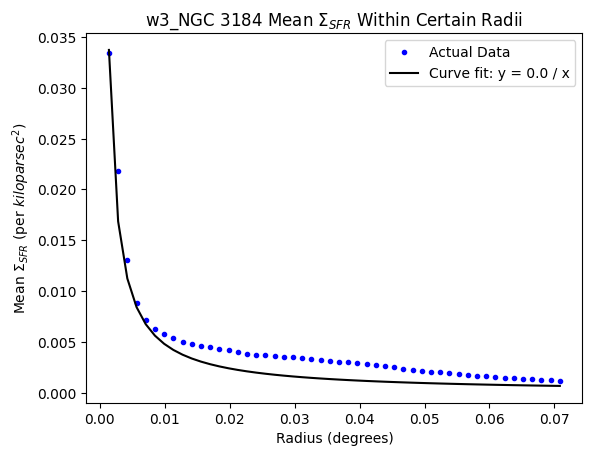

-0.000741638039900657


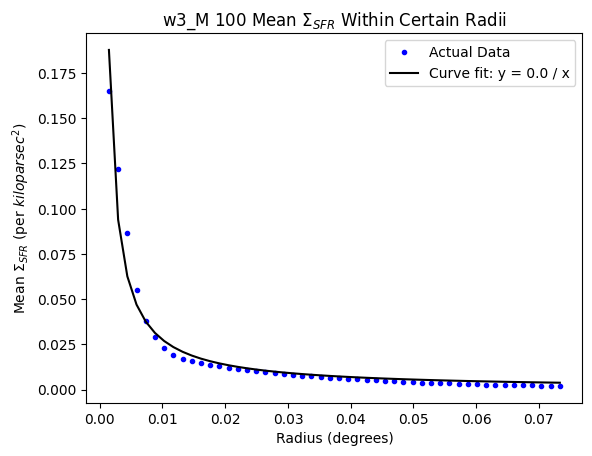

0.0025556206180178584


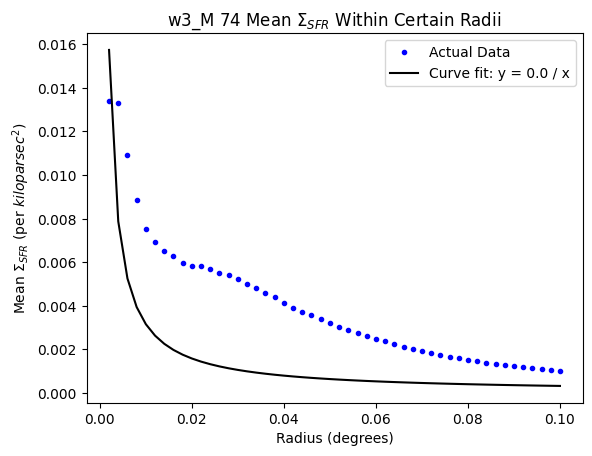

0.0004435778779659745


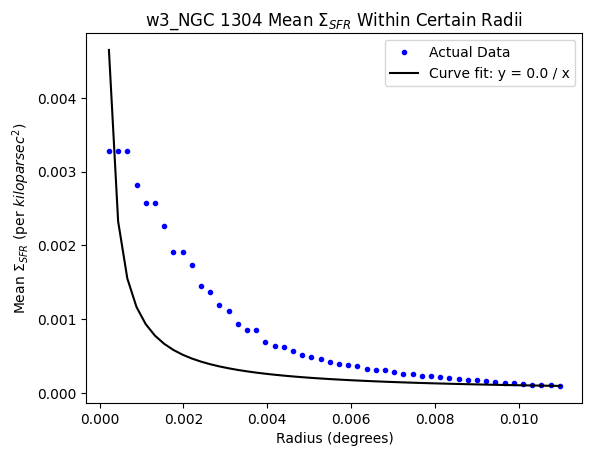

0.006320054088365396


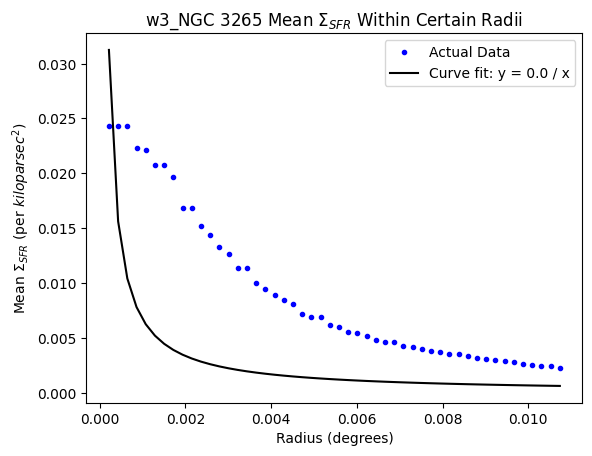

0.0003238692553804573


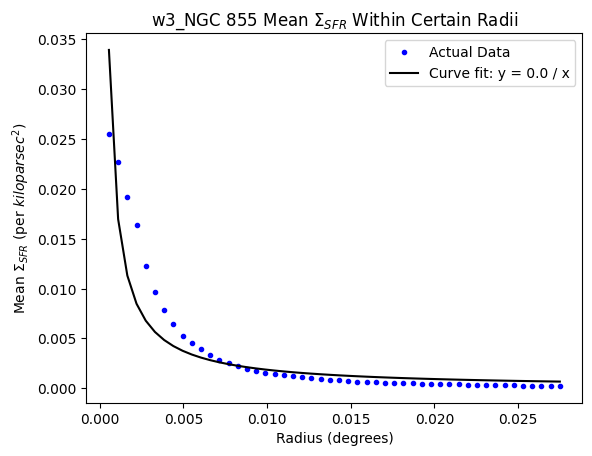

-0.0005487460798928114


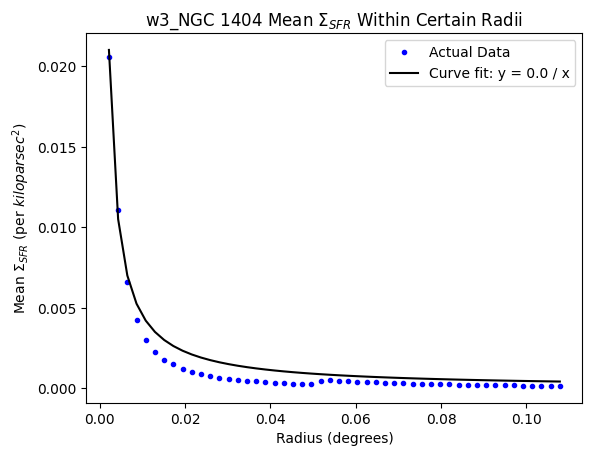

0.00029652339821153436


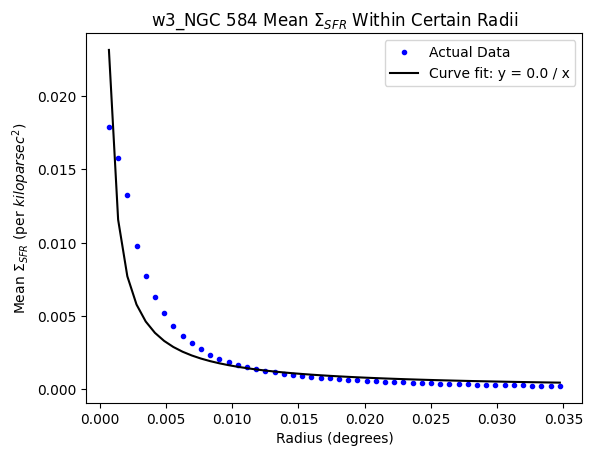

0.00029214537574163827


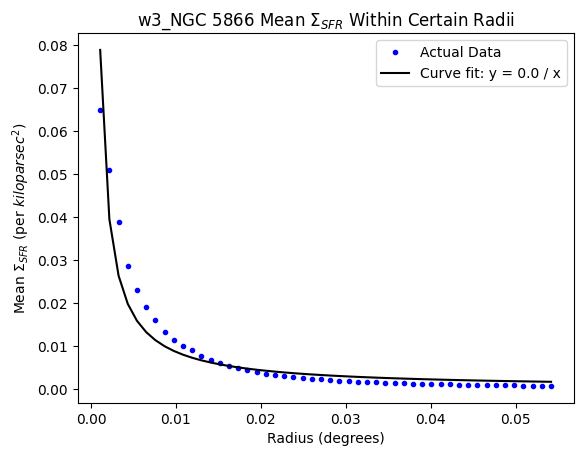

In [18]:
best_fit_eqs = []

for current_galaxy, current_galaxy_for_data in zip(wise_galaxies_list, galaxies_list_for_data):
    galaxy_name = current_galaxy[3:-5]

    for row in galaxy_info:
        if galaxy_name == row[0]: 
            galaxy_radius =  float(row[2]) * u.arcsec.to(u.deg)
            galaxy_type = row[3] 
            galaxy_id = current_galaxy[0:3] 
            
            data = fits.getdata(current_galaxy_for_data)
            header = fits.getheader(current_galaxy_for_data)
            w = WCS(header)
            rows, cols = np.indices(data.shape)
            ra, dec = w.all_pix2world(cols, rows, 1)
            ra_ctr = header['CRVAL1']
            dec_ctr = header['CRVAL2']

            dist_array = np.sqrt((ra_ctr - ra)**2 + (dec_ctr - dec)**2)
            radius_array = np.zeros(sub_sec) 
            
            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec
                radius_array[i] = radius
                
            bins_mean = np.zeros(sub_sec)

            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec 
                radius_inds = np.where(dist_array < radius) 
                im_vals = data[radius_inds]
                radius_mean = np.mean(im_vals)
                radius_sum = np.sum(im_vals)
                
                if (galaxy_id == w1):
                    stellar_mass_mean = 3.3e2 * radius_mean
                    bins_mean[i] = stellar_mass_mean
                    
                if (galaxy_id == w3):
                    sfr_mean = 3.77e-3 * radius_mean 
                    bins_mean[i] = sfr_mean

            inverse_radii = 1 / radius_array

            k, b = np.polyfit(inverse_radii, bins_mean, 1)

            print(b) # ig this just doesn't matter??

            curve_output = k / radius_array

            plt.plot(radius_array, bins_mean, 'b.', label='Actual Data') 
            plt.plot(radius_array, curve_output, 'k', label=f'Curve fit: y = {k.round(3)} / x')
            plt.legend(loc='upper right')
            plt.xlabel('Radius (degrees)')
            plt.ylabel('Mean $\Sigma_{SFR}$ (per $kiloparsec^2$)')
            plt.title(galaxy_id + galaxy_name + ' Mean $\Sigma_{SFR}$ Within Certain Radii')
            plt.show()

## GALEX Data Retrieval

### DONT USE DATA IT IS ALL MESSSED UP
#### Problems:
- Some galaxy files are messed up and wont return data/pictures that makes sense
    - M 74, NGC 3184, NGC 3938 (fuv only)
- Update again lol

In [15]:
"""fuv_galaxies_list = [FUV + sub for sub in galaxies_list_fits]
nuv_galaxies_list = [NUV + sub for sub in galaxies_list_fits]

galex_galaxies_list = fuv_galaxies_list + nuv_galaxies_list

galaxies_list_for_data = [prefix + sub for sub in galex_galaxies_list]"""

'fuv_galaxies_list = [FUV + sub for sub in galaxies_list_fits]\nnuv_galaxies_list = [NUV + sub for sub in galaxies_list_fits]\n\ngalex_galaxies_list = fuv_galaxies_list + nuv_galaxies_list\n\ngalaxies_list_for_data = [prefix + sub for sub in galex_galaxies_list]'

In [16]:
"""for current_galaxy, current_galaxy_for_data in zip(galex_galaxies_list, galaxies_list_for_data):
    galaxy_name = current_galaxy[4:-5]
    
    for check in range(len(galaxy_info)): 
        if galaxy_name == galaxy_info[check][0]:
            galaxy_radius =  float(galaxy_info[check][2]) * u.arcsec.to(u.deg)
            galaxy_type =  galaxy_info[check][3]
            galaxy_id = current_galaxy[0:4] 
            
            data = fits.getdata(current_galaxy_for_data)
            header = fits.getheader(current_galaxy_for_data)
            w = WCS(header)
            rows, cols = np.indices(data.shape)
            ra, dec = w.all_pix2world(cols, rows, 1)
            ra_ctr = header['CRVAL1']
            dec_ctr = header['CRVAL2']

            dist_array = np.sqrt((ra_ctr - ra)**2 + (dec_ctr - dec)**2)
            radius_array = np.zeros(sub_sec)
            
            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec
                radius_array[i] = radius
                
            bins_mean = np.zeros(sub_sec)
            bins_sum = np.zeros(sub_sec)

            for i in range(sub_sec):
                radius = (i + 1) * galaxy_radius / sub_sec
                radius_inds = np.where(dist_array < radius)
                im_vals = data[radius_inds]
                radius_mean = np.mean(im_vals)
                radius_sum = np.sum(im_vals)
                            
                if (galaxy_id == FUV):
                    sfr_mean = 1.04e-1 * radius_mean
                    sfr_sum = 1.04e-1 * radius_sum
                    bins_mean[i] = sfr_mean
                    bins_sum[i] = sfr_sum
                if (galaxy_id == NUV):
                    sfr_mean = 1.05e-1 * radius_mean
                    sfr_sum = 1.05e-1 * radius_sum
                    bins_mean[i] = sfr_mean
                    bins_sum[i] = sfr_sum
                
            plt.plot(radius_array, bins_mean, 'b.')
            plt.xlabel('Radius (degrees)')
            plt.ylabel('Mean $\Sigma_{SFR}$ (per $kiloparsec^2$)')
            plt.title(galaxy_name + ' Mean $\Sigma_{SFR}$ Within Certain Radii')
            if galaxy_type == spiral:
                if (galaxy_id == FUV): plt.savefig(f'saved avg sfr plots/FUV/spiral-{galaxy_name}-avg.png')
                if (galaxy_id == NUV): plt.savefig(f'saved avg sfr plots/NUV/spiral-{galaxy_name}-avg.png')
            if galaxy_type == elliptical:
                if (galaxy_id == FUV): plt.savefig(f'saved avg sfr plots/FUV/elliptical-{galaxy_name}-avg.png')
                if (galaxy_id == NUV): plt.savefig(f'saved avg sfr plots/NUV/elliptical-{galaxy_name}-avg.png') 
            plt.close()

            plt.plot(radius_array, bins_sum, 'r.')
            plt.xlabel('Radius (degrees)')
            plt.ylabel('Sum of $\Sigma_{SFR}$ (per $kiloparsec^2$)')
            plt.title(galaxy_name + ' Sum of $\Sigma_{SFR}$ Within Certain Radii')
            if galaxy_type == spiral:
                if (galaxy_id == FUV): plt.savefig(f'saved sum of sfr plots/FUV/spiral-{galaxy_name}-sum.png')
                if (galaxy_id == NUV): plt.savefig(f'saved sum of sfr plots/NUV/spiral-{galaxy_name}-sum.png')
            if galaxy_type == elliptical:
                if (galaxy_id == FUV): plt.savefig(f'saved sum of sfr plots/FUV/elliptical-{galaxy_name}-sum.png')
                if (galaxy_id == NUV): plt.savefig(f'saved sum of sfr plots/NUV/elliptical-{galaxy_name}-sum.png')
            plt.close()

            median = np.median(data)
            deviations = abs(data - median)
            mad = np.median(deviations)

            plt.imshow(data, vmin = median - 3*mad, vmax = median + 30*mad, origin='lower', cmap='afmhot')
            plt.title(galaxy_name)
            if galaxy_type == spiral:
                if (galaxy_id == FUV): plt.savefig(f'saved galaxy images/FUV/spiral-{galaxy_name}.png')
                if (galaxy_id == NUV): plt.savefig(f'saved galaxy images/NUV/spiral-{galaxy_name}.png')
            if galaxy_type == elliptical:
                if (galaxy_id == FUV): plt.savefig(f'saved galaxy images/FUV/elliptical-{galaxy_name}.png')
                if (galaxy_id == NUV): plt.savefig(f'saved galaxy images/NUV/elliptical-{galaxy_name}.png')
            plt.close()

            if galaxy_type == spiral:
                if (galaxy_id == FUV): np.savetxt(f'saved raw data/FUV/spiral/{galaxy_name}-raw_mean.csv', bins_mean, delimiter=',')
                if (galaxy_id == NUV): np.savetxt(f'saved raw data/NUV/spiral/{galaxy_name}-raw_mean.csv', bins_mean, delimiter=',')
            if galaxy_type == elliptical:
                if (galaxy_id == FUV): np.savetxt(f'saved raw data/FUV/elliptical/{galaxy_name}-raw_mean.csv', bins_mean, delimiter=',')
                if (galaxy_id == NUV): np.savetxt(f'saved raw data/NUV/elliptical/{galaxy_name}-raw_mean.csv', bins_mean, delimiter=',')
            
            if galaxy_type == spiral:
                if (galaxy_id == FUV): np.savetxt(f'saved raw data/FUV/spiral/{galaxy_name}-raw_sum.csv', bins_sum, delimiter=',')    
                if (galaxy_id == NUV): np.savetxt(f'saved raw data/NUV/spiral/{galaxy_name}-raw_sum.csv', bins_sum, delimiter=',')
            if galaxy_type == elliptical:
                if (galaxy_id == FUV): np.savetxt(f'saved raw data/FUV/elliptical/{galaxy_name}-raw_sum.csv', bins_sum, delimiter=',')
                if (galaxy_id == NUV): np.savetxt(f'saved raw data/NUV/elliptical/{galaxy_name}-raw_sum.csv', bins_sum, delimiter=',')
"""

"for current_galaxy, current_galaxy_for_data in zip(galex_galaxies_list, galaxies_list_for_data):\n    galaxy_name = current_galaxy[4:-5]\n    \n    for check in range(len(galaxy_info)): \n        if galaxy_name == galaxy_info[check][0]:\n            galaxy_radius =  float(galaxy_info[check][2]) * u.arcsec.to(u.deg)\n            galaxy_type =  galaxy_info[check][3]\n            galaxy_id = current_galaxy[0:4] \n            \n            data = fits.getdata(current_galaxy_for_data)\n            header = fits.getheader(current_galaxy_for_data)\n            w = WCS(header)\n            rows, cols = np.indices(data.shape)\n            ra, dec = w.all_pix2world(cols, rows, 1)\n            ra_ctr = header['CRVAL1']\n            dec_ctr = header['CRVAL2']\n\n            dist_array = np.sqrt((ra_ctr - ra)**2 + (dec_ctr - dec)**2)\n            radius_array = np.zeros(sub_sec)\n            \n            for i in range(sub_sec):\n                radius = (i + 1) * galaxy_radius / sub_sec\n       

# Section 2: Data Analysis

In [17]:
# t test somehow, use curve fit equations